In [2]:
# load packages
import pandas as pd
import plotly
import plotly.express as px
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline, splrep, splev
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns
import datetime
from scipy.interpolate import interp1d

In [3]:
nasa53 = pd.read_parquet('NASACell53.parquet')
nasa54 = pd.read_parquet('NASACell54.parquet')
nasa55 = pd.read_parquet('NASACell55.parquet')
nasa56 = pd.read_parquet('NASACell56.parquet')

In [4]:
nasa_all = pd.concat([nasa53, nasa54, nasa55, nasa56], axis = 0)

In [5]:
nasa_all.columns

Index(['Cycle', 'Source', 'Chemistry', 'Charge_Type', 'Cell', 'Step',
       'Cycle_Type', 'Time', 'Voltage', 'Instantaneous Capacity',
       'Charge_Capacity', 'Discharge_Capacity', 'Temperature',
       'Ambient_Temperature', 'Current', 'Step Time', 'Reference Capacity',
       'Cycle Time'],
      dtype='object')

In [6]:
nasa_all = nasa_all[['Source', 'Chemistry', 'Cell', 'Cycle', 'Step', 'Cycle_Type', 'Time',
       'Voltage', 'Reference Capacity', 'Instantaneous Capacity',
       'Charge_Capacity', 'Discharge_Capacity', 'Temperature',
       'Ambient_Temperature', 'Current', 'Charge_Type']]

In [7]:
nasa_all['Cell'].unique()

array([53., 54., 55., 56.])

In [8]:
# filter nasa_all to nasa / just discharge steps
nasa = nasa_all[(nasa_all['Cycle_Type'] == 'discharge')]
nasa['Cell'].unique()

array([53., 54., 55., 56.])

In [9]:
nasa_53 = nasa[nasa['Cell'] == 53] 
nasa_54 = nasa[nasa['Cell'] == 54]
nasa_55 = nasa[nasa['Cell'] == 55]
nasa_56 = nasa[nasa['Cell'] == 56]

print(nasa_53.shape[0], nasa_54.shape[0], nasa_55.shape[0], nasa_56.shape[0])

11090 22665 22662 22662


In [10]:
nasa_df = pd.concat([nasa_53, nasa_54, nasa_55, nasa_56], axis = 0)
nasa_df.head()

,Source,Chemistry,Cell,Cycle,Step,Cycle_Type,Time,Voltage,Reference Capacity,Instantaneous Capacity,Charge_Capacity,Discharge_Capacity,Temperature,Ambient_Temperature,Current,Charge_Type
0,NASA,NaN,53.0,0.0,0.0,discharge,0.000,4.081,4697.195,0.000,NaN,NaN,5.648,4.0,-0.003,Continuous
1,NASA,NaN,53.0,0.0,0.0,discharge,9.453,4.082,4697.195,-0.025,NaN,NaN,5.655,4.0,-0.003,Continuous
2,NASA,NaN,53.0,0.0,0.0,discharge,21.265,3.678,4697.195,-11.925,NaN,NaN,5.714,4.0,-2.013,Continuous
3,NASA,NaN,53.0,0.0,0.0,discharge,32.218,3.653,4697.195,-33.971,NaN,NaN,5.813,4.0,-2.014,Continuous
4,NASA,NaN,53.0,0.0,0.0,discharge,43.203,3.631,4697.195,-56.080,NaN,NaN,5.936,4.0,-2.013,Continuous


In [11]:
nasa_df.to_csv('nasa_rebound_data.csv')
nasa_df

,Source,Chemistry,Cell,Cycle,Step,Cycle_Type,Time,Voltage,Reference Capacity,Instantaneous Capacity,Charge_Capacity,Discharge_Capacity,Temperature,Ambient_Temperature,Current,Charge_Type
0,NASA,NaN,53.0,0.0,0.0,discharge,0.000,4.081,4697.195,0.000,NaN,NaN,5.648,4.0,-0.003,Continuous
1,NASA,NaN,53.0,0.0,0.0,discharge,9.453,4.082,4697.195,-0.025,NaN,NaN,5.655,4.0,-0.003,Continuous
2,NASA,NaN,53.0,0.0,0.0,discharge,21.265,3.678,4697.195,-11.925,NaN,NaN,5.714,4.0,-2.013,Continuous
3,NASA,NaN,53.0,0.0,0.0,discharge,32.218,3.653,4697.195,-33.971,NaN,NaN,5.813,4.0,-2.014,Continuous
4,NASA,NaN,53.0,0.0,0.0,discharge,43.203,3.631,4697.195,-56.080,NaN,NaN,5.936,4.0,-2.013,Continuous
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257582,NASA,NaN,56.0,125.0,250.0,discharge,1338788.969,3.722,4064.612,-4077.569,NaN,NaN,11.432,4.0,-0.003,Continuous
257583,NASA,NaN,56.0,125.0,250.0,discharge,1338802.203,3.724,4064.612,-4077.608,NaN,NaN,11.310,4.0,-0.004,Continuous
257584,NASA,NaN,56.0,125.0,250.0,discharge,1338815.406,3.725,4064.612,-4077.637,NaN,NaN,11.176,4.0,-0.002,Continuous
257585,NASA,NaN,56.0,125.0,250.0,discharge,1338828.687,3.726,4064.612,-4077.639,NaN,NaN,11.037,4.0,0.000,Continuous


In [12]:
# Load the dataset
file_path = "nasa_rebound_data.csv"
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
df.head()

,Unnamed: 0,Source,Chemistry,Cell,Cycle,Step,Cycle_Type,Time,Voltage,Reference Capacity,Instantaneous Capacity,Charge_Capacity,Discharge_Capacity,Temperature,Ambient_Temperature,Current,Charge_Type
0,0,NASA,NaN,53.0,0.0,0.0,discharge,0.000,4.081,4697.195,0.000,NaN,NaN,5.648,4.0,-0.003,Continuous
1,1,NASA,NaN,53.0,0.0,0.0,discharge,9.453,4.082,4697.195,-0.025,NaN,NaN,5.655,4.0,-0.003,Continuous
2,2,NASA,NaN,53.0,0.0,0.0,discharge,21.265,3.678,4697.195,-11.925,NaN,NaN,5.714,4.0,-2.013,Continuous
3,3,NASA,NaN,53.0,0.0,0.0,discharge,32.218,3.653,4697.195,-33.971,NaN,NaN,5.813,4.0,-2.014,Continuous
4,4,NASA,NaN,53.0,0.0,0.0,discharge,43.203,3.631,4697.195,-56.080,NaN,NaN,5.936,4.0,-2.013,Continuous


This dataset contains battery cycling data from NASA.

Columns include Cycle_Type, Time, Voltage, Capacity, Temperature, and Current, among others.

Some missing values are present, particularly in Chemistry, Charge_Capacity, and Discharge_Capacity.

The Cycle_Type indicates different stages like "discharge" and possibly "charge."

The Temperature and Ambient_Temperature columns track thermal behavior.

In [14]:
# Display basic info about the dataset for debugging
print("Dataset info:")
print(f"Shape: {df.shape}")

Dataset info:
Shape: (79079, 17)


In [15]:
# Display basic info about the dataset for debugging
print("Dataset info:")
print(f"Columns: {df.columns.tolist()}")

Dataset info:
Columns: ['Unnamed: 0', 'Source', 'Chemistry', 'Cell', 'Cycle', 'Step', 'Cycle_Type', 'Time', 'Voltage', 'Reference Capacity', 'Instantaneous Capacity', 'Charge_Capacity', 'Discharge_Capacity', 'Temperature', 'Ambient_Temperature', 'Current', 'Charge_Type']


In [16]:
# Display basic info about the dataset for debugging
print("Dataset info:")
print(f"Missing values per column:")
print(df.isna().sum())

Dataset info:
Missing values per column:
Unnamed: 0                    0
Source                        0
Chemistry                 79079
Cell                          0
Cycle                         0
Step                          0
Cycle_Type                    0
Time                          0
Voltage                       0
Reference Capacity            0
Instantaneous Capacity        0
Charge_Capacity           79079
Discharge_Capacity        79079
Temperature                   0
Ambient_Temperature           0
Current                       0
Charge_Type                   0
dtype: int64


In [17]:
# Check if "Reference Capacity" or "Reference_Capacity" exists
if "Reference Capacity" in df.columns:
    ref_capacity_col = "Reference Capacity"
    print(f"Using 'Reference Capacity' column")
elif "Reference_Capacity" in df.columns:
    ref_capacity_col = "Reference_Capacity"
    print(f"Using 'Reference_Capacity' column")
else:
    print("WARNING: No reference capacity column found! Creating dummy values.")
    # Create dummy reference capacity values for testing
    df["Reference_Capacity"] = 2.0 - (df["Cycle"] * 0.01)  # Simple linear degradation model
    ref_capacity_col = "Reference_Capacity"

Using 'Reference Capacity' column


In [18]:
# Get unique cycle indices
unique_cycles = df["Cell"].unique()
# Get unique cell indices
unique_cells = df["Cell"].unique()
print(f"Found {len(unique_cells)} cells in dataset: {unique_cells}")
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_cycles)))  # Generate unique colors

Found 4 cells in dataset: [53. 54. 55. 56.]


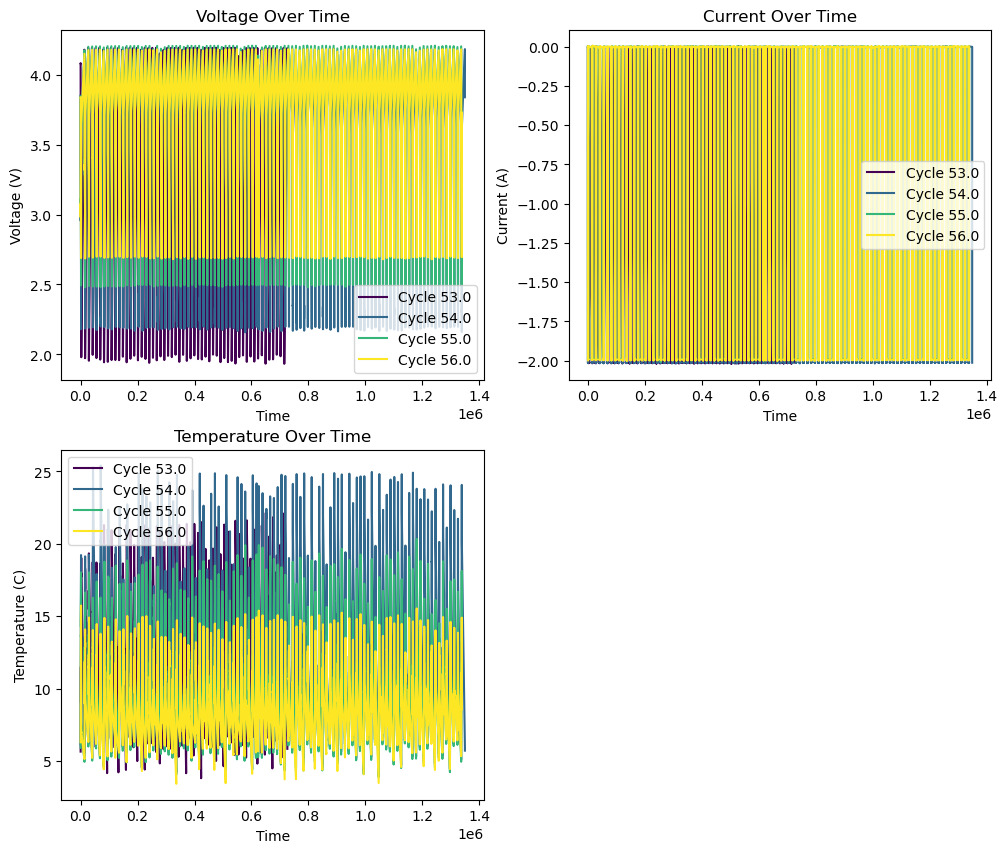

In [19]:
# Create subplots to visualize battery metrics over time
plt.figure(figsize=(12, 10))

# Voltage over time
plt.subplot(2, 2, 1)
for cycle, color in zip(unique_cycles, colors):
    cycle_data = df[df["Cell"] == cycle]
    plt.plot(cycle_data["Time"], cycle_data["Voltage"], label=f"Cycle {cycle}", color=color)
plt.xlabel("Time")
plt.ylabel("Voltage (V)")
plt.title("Voltage Over Time")
plt.legend()

# Current over time
plt.subplot(2, 2, 2)
for cycle, color in zip(unique_cycles, colors):
    cycle_data = df[df["Cell"] == cycle]
    plt.plot(cycle_data["Time"], cycle_data["Current"], label=f"Cycle {cycle}", color=color)
plt.xlabel("Time")
plt.ylabel("Current (A)")
plt.title("Current Over Time")
plt.legend()

# Temperature over time
plt.subplot(2, 2, 3)
for cycle, color in zip(unique_cycles, colors):
    cycle_data = df[df["Cell"] == cycle]
    plt.plot(cycle_data["Time"], cycle_data["Temperature"], label=f"Cycle {cycle}", color=color)
plt.xlabel("Time")
plt.ylabel("Temperature (C)")
plt.title("Temperature Over Time")
plt.legend()

# Battery Health Monitoring and Analysis Methodology

The methodology I'm using for battery health monitoring and analysis is based on **Functional Data Analysis (FDA)** combined with a **multi-tier threshold system**. Here's a brief overview:

## 1. Functional Representation of Battery Signals
- Converting raw **voltage, current, and temperature** time-series data into continuous functional representations using **B-spline smoothing**.
- Normalizing time to a **0-1 range** to standardize curves regardless of test duration.

## 2. Functional Principal Component Analysis (FPCA)
- Applying **PCA** to the smoothed voltage curves to extract the **main modes of variation**.
- Using the **first few principal components** to capture dominant patterns in battery discharge behavior.
- This **dimensionality reduction** helps identify **underlying patterns** across different cells and cycles.

## 3. Capacity Loss Prediction
- Building a **Functional Linear Model (FLM)** that relates **FPCA scores** to **capacity loss percentage**.
- Using the **maximum observed capacity** as a reference point to calculate deterioration.
- Predicting **remaining useful life** based on degradation trends.

## 4. Anomaly Detection
- Calculating **Mahalanobis distance** in FPCA space to identify **abnormal battery behavior**.
- Setting **detection thresholds** based on the **statistical distribution** of distances.
- Flagging **anomalies** that could indicate **accelerated degradation or failure risks**.

## 5. Multi-Tier Alert System
- Implementing **three threshold levels** for battery health monitoring:  
  - **Monitor**  
  - **Warning**  
  - **Replace**  
- Automatically generating **maintenance recommendations** based on **current capacity** and **anomaly detection**.
- Providing **time-to-replacement estimates** based on **degradation rate**.

## 6. Fleet Management Capabilities
- Analyzing and comparing **all cells** in the battery fleet.
- Prioritizing cells based on **health status** and **anomalous behavior**.
- Generating **comprehensive status reports** and **visualizations**.

This methodology provides a **systematic approach** to battery health monitoring that combines **advanced statistical techniques** with **practical threshold-based decision rules** for **maintenance planning**.


In [21]:
# Define threshold levels (same as in BMS)
threshold_levels = {
    "Monitor": 80,  # Start monitoring when SoH drops below 80%
    "Warning": 50,  # Warning when SoH drops below 50%
    "Replace": 20   # Critical replacement threshold at 20%
}
# --- FUNCTIONAL DATA PROCESSING (BMS Approach) ---
print("\nProcessing and creating functional representations of battery data...")

# Initialize variables to store functional data
functional_data = {}
all_cell_data = {}
all_cell_capacities = []
cycles_data = []  # This will store the voltage curves for FPCA
cycle_indices = []
cell_indices = []
capacities = []


Processing and creating functional representations of battery data...


In [22]:
# Process each cell to extract functional representations
for cell_id in unique_cells:
    cell_data = df[df["Cell"] == cell_id]
    cycles = sorted(cell_data["Cycle"].unique())
    
    print(f"Processing cell {cell_id} with {len(cycles)} cycles...")
    cell_functional_data = {}
    
    for cycle in cycles:
        cycle_data = cell_data[cell_data["Cycle"] == cycle]
        
        # Debug info
        print(f"  Cycle {cycle}: {len(cycle_data)} data points")
        
        # Skip cycles with too few data points
        n_basis = 15  # Same as in BMS
        if len(cycle_data) < n_basis:
            print(f"  Skipping cycle {cycle} - insufficient data points (need at least {n_basis})")
            continue
        
        # Store reference capacity
        if ref_capacity_col in cycle_data.columns and not cycle_data[ref_capacity_col].isna().all():
            ref_capacity = cycle_data[ref_capacity_col].iloc[0]
            all_cell_capacities.append(ref_capacity)
            print(f"  Cycle {cycle} reference capacity: {ref_capacity}")
        else:
            print(f"  Skipping cycle {cycle} - missing reference capacity")
            continue
        
        time_points = cycle_data["Time"].values
        
        # Skip if time range is too small
        time_range = time_points.max() - time_points.min()
        if time_range < 1:
            print(f"  Skipping cycle {cycle} - insufficient time range ({time_range})")
            continue
            
        # Normalize time to 0-1 range (BMS approach)
        time_normalized = (time_points - time_points.min()) / time_range
        
        # Initialize cycle data (BMS structure)
        cell_functional_data[cycle] = {
            'reference_capacity': ref_capacity,
            'time_original': time_points,
            'time_normalized': time_normalized,
            'functional_vars': {}
        }
        
        # Create B-spline representation for each variable
        for var in ['Voltage', 'Current', 'Temperature']:
            # Skip if variable is missing
            if var not in cycle_data.columns or cycle_data[var].isna().all():
                print(f"  Cycle {cycle}: {var} data is missing")
                continue
            
            values = cycle_data[var].values
            
            try:
                # Fit B-spline using BMS parameters with error handling
                # First check for duplicate x values
                if len(np.unique(time_normalized)) < len(time_normalized):
                    print(f"  Cycle {cycle}: Duplicate time values found for {var}, cleaning data...")
                    # Get unique indices
                    _, unique_idx = np.unique(time_normalized, return_index=True)
                    time_normalized_clean = time_normalized[unique_idx]
                    values_clean = values[unique_idx]
                else:
                    time_normalized_clean = time_normalized
                    values_clean = values
                
                # Ensure data is sorted by time
                sort_idx = np.argsort(time_normalized_clean)
                time_normalized_clean = time_normalized_clean[sort_idx]
                values_clean = values_clean[sort_idx]
                
                # Use a more robust approach for spline fitting
                k = min(3, len(time_normalized_clean) - 1)  # Degree of spline
                tck = splrep(time_normalized_clean, values_clean, k=k, s=0.1)
                
                # Evaluate on a dense grid for further analysis
                t_dense = np.linspace(0, 1, 100)
                values_smooth = splev(t_dense, tck)
                
                cell_functional_data[cycle]['functional_vars'][var] = {
                    'raw': values,
                    'smooth': values_smooth,
                    'grid': t_dense
                }
                
                # For voltage, store the smoothed curve for FPCA
                if var == 'Voltage':
                    print(f"  Successfully processed Voltage for cell {cell_id}, cycle {cycle}")
                    cycles_data.append(values_smooth)
                    cycle_indices.append(cycle)
                    cell_indices.append(cell_id)
                    capacities.append(ref_capacity)
                
            except Exception as e:
                print(f"  Error processing {var} for cycle {cycle}: {e}")
    
    all_cell_data[cell_id] = cell_functional_data

Processing cell 53.0 with 56 cycles...
  Cycle 0.0: 215 data points
  Cycle 0.0 reference capacity: 4697.195
  Successfully processed Voltage for cell 53.0, cycle 0.0
  Cycle 2.0: 233 data points
  Cycle 2.0 reference capacity: 5122.754
  Successfully processed Voltage for cell 53.0, cycle 2.0
  Cycle 3.0: 229 data points
  Cycle 3.0 reference capacity: 5046.508
  Successfully processed Voltage for cell 53.0, cycle 3.0
  Cycle 4.0: 225 data points
  Cycle 4.0 reference capacity: 4977.976
  Successfully processed Voltage for cell 53.0, cycle 4.0
  Cycle 5.0: 223 data points
  Cycle 5.0 reference capacity: 4950.457
  Successfully processed Voltage for cell 53.0, cycle 5.0
  Cycle 6.0: 222 data points
  Cycle 6.0 reference capacity: 4947.98
  Successfully processed Voltage for cell 53.0, cycle 6.0
  Cycle 8.0: 223 data points
  Cycle 8.0 reference capacity: 4991.335
  Successfully processed Voltage for cell 53.0, cycle 8.0
  Cycle 9.0: 221 data points
  Cycle 9.0 reference capacity: 4962.

# Core Data Processing Loop of the Battery Management System

The code above is the **core data processing loop** of the Battery Management System. It iterates through each battery cell and its cycles to create **functional representations** of the battery signals. 

## 1. Cell-by-Cycle Processing
- The **outer loop** iterates through each **unique cell ID**.
- For each cell:
  - It extracts **all cycle numbers** and sorts them.
  - It then processes **each cycle individually**.

## 2. Data Quality Filtering
- Checks if a cycle has **enough data points** (**at least 15**, matching BMS requirements).
- Verifies that **reference capacity data** exists for the cycle.
- Ensures the **time range is sufficient** (**at least 1 unit**).
- These **filters** help ensure the **quality** of the functional representation.

## 3. Time Normalization
- Converts the **original time points** to a **normalized 0-1 range**.
- This **standardization** allows **comparison between cycles** of different durations.

## 4. Data Structure Creation
- Creates a **hierarchical data structure** for each cycle with:
  - **Reference capacity**
  - **Original time points**
  - **Normalized time points**
  - A **placeholder for functional variables** (Voltage, Current, Temperature)

## 5. B-Spline Representation
- For each variable (**Voltage, Current, Temperature**):
  - Handles potential **data issues** like **duplicate time values**.
  - Ensures data is properly **sorted by time**.
  - Determines appropriate **spline degree** based on available points.
  - Fits a **B-spline** to create a **smooth functional representation**.
  - Evaluates the **spline on a dense grid of 100 points**.

## 6. FPCA Data Collection
- For **Voltage curves specifically**:
  - Stores the **smoothed curve** for later **FPCA analysis**.
  - Tracks corresponding **cycle and cell information**.
  - Maintains the **relationship between curves and capacity values**.

## 7. Error Handling
- Implements **robust error handling** throughout the process.
- Provides **detailed diagnostic information**.
- **Skips problematic cycles** rather than failing entirely.

## 8. Data Organization
- Stores **all the processed data** for each cell in the `all_cell_data` dictionary.
- Specifically collects **voltage curves** in `cycles_data` for **FPCA**.

---

This process transforms **raw, discrete battery measurements** into **continuous functional representations** that capture the **underlying patterns** of battery behavior across different cycles and cells. The **careful filtering** and **error handling** ensure that **only high-quality data** is used for subsequent analysis.

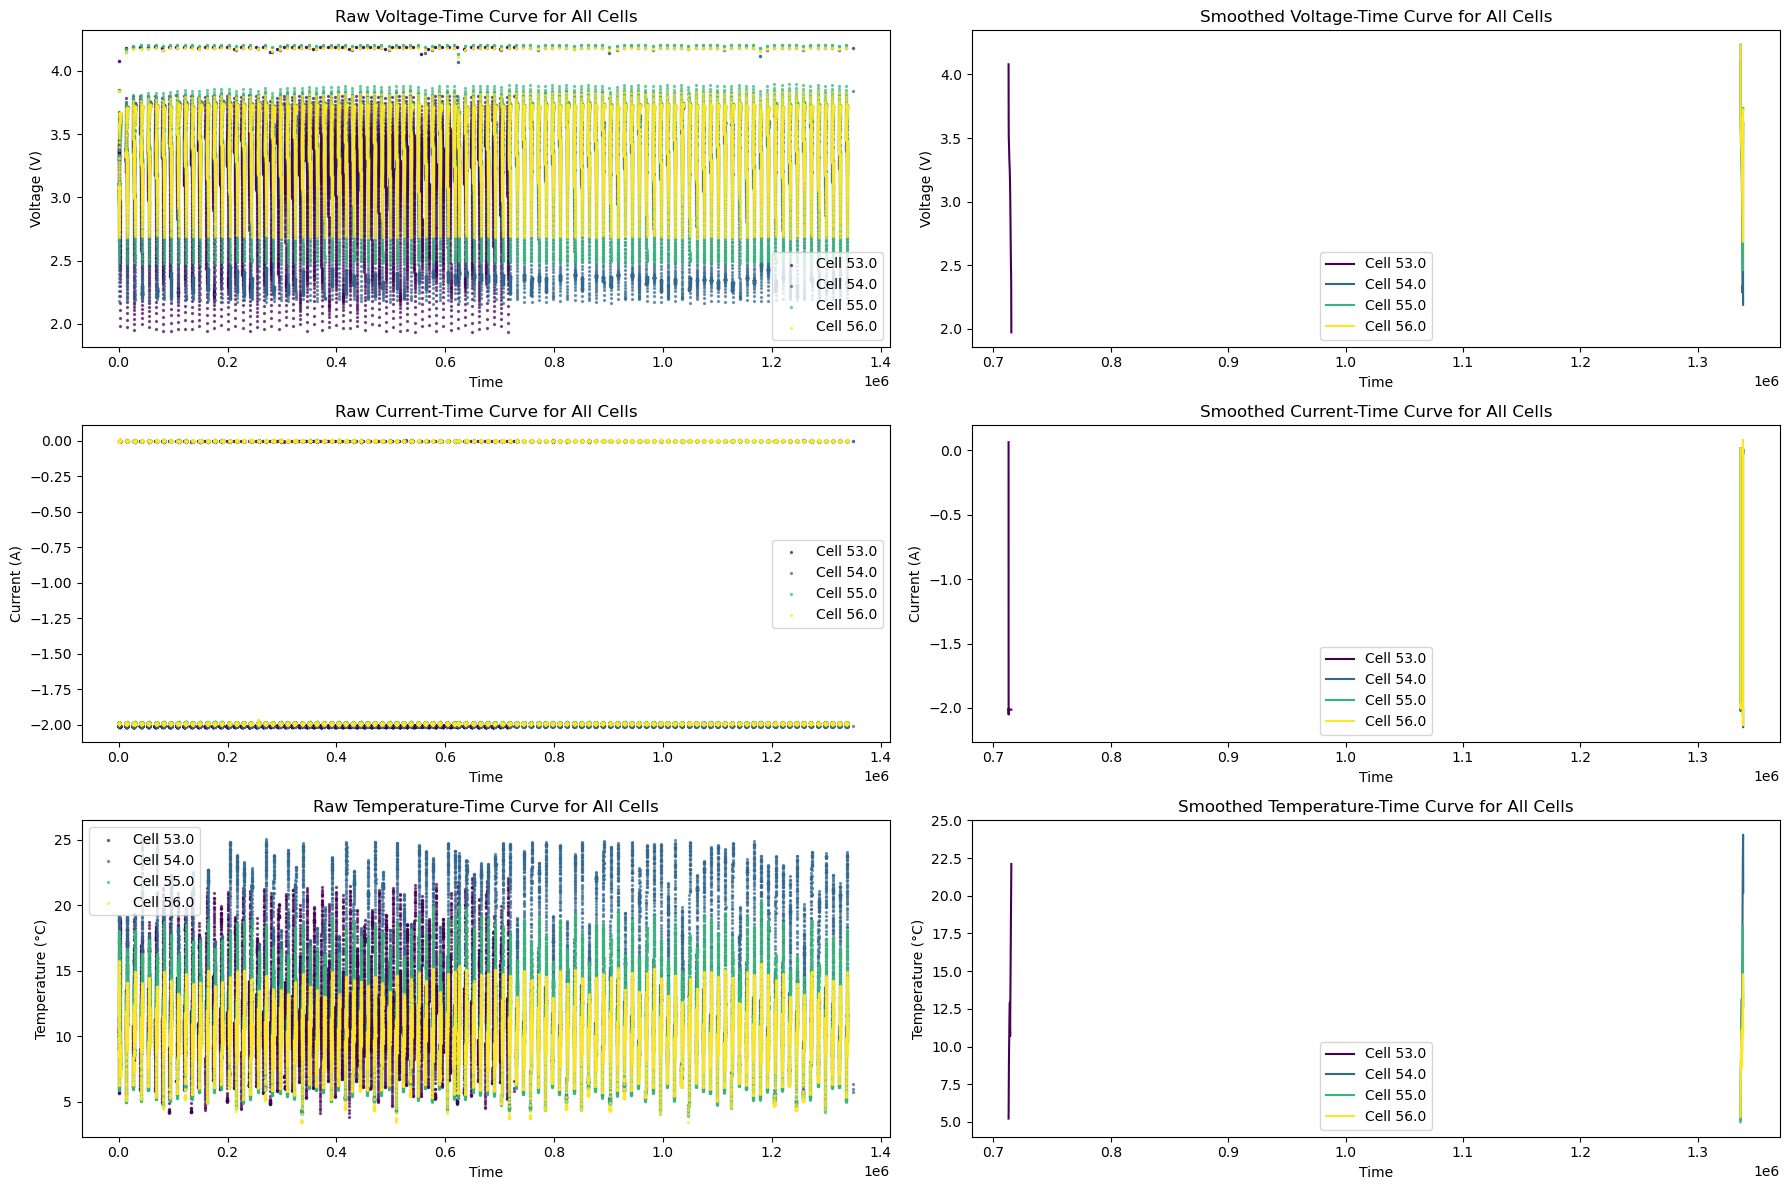

In [24]:
# Define sample_cells (e.g., first 4 cells from the dataset)
unique_cells = df["Cell"].unique()
sample_cells = unique_cells[:4]  # Adjust this if you want more or fewer cells

# Ensure adjusted_time exists for all smoothed data
for cell_id in all_cell_data.keys():
    last_cycle = max(all_cell_data[cell_id].keys())
    for var in ["Voltage", "Current", "Temperature"]:
        if var in all_cell_data[cell_id][last_cycle]["functional_vars"]:
            smooth_values = all_cell_data[cell_id][last_cycle]["functional_vars"][var]["smooth"]
            original_time = all_cell_data[cell_id][last_cycle]["time_original"]

            # Generate adjusted time if missing
            if "adjusted_time" not in all_cell_data[cell_id][last_cycle]["functional_vars"][var]:
                time_interp = interp1d(
                    np.linspace(0, 1, len(original_time)), original_time, kind='linear', fill_value="extrapolate"
                )
                adjusted_time = time_interp(np.linspace(0, 1, len(smooth_values)))

                # Store the adjusted time
                all_cell_data[cell_id][last_cycle]["functional_vars"][var]["adjusted_time"] = adjusted_time
            else:
                print(f"Adjusted time already exists for {var} in cell {cell_id}, cycle {last_cycle}")

# Create the updated visualization with Raw vs. Smoothed data
fig, axes = plt.subplots(3, 2, figsize=(18, 12))  # 3 variables, 2 columns (Raw vs. Smoothed)

# Plot Raw and Smoothed Voltage-Time Curves
for i, cell_id in enumerate(sample_cells):
    df_cell = df[df["Cell"] == cell_id].sort_values(by="Time")
    color = colors[i]  # Use index-based color assignment

    # Raw Voltage
    axes[0, 0].scatter(df_cell["Time"], df_cell["Voltage"], s=2, color=color, alpha=0.6, label=f"Cell {cell_id}")

    # Smoothed Voltage
    last_cycle = max(all_cell_data[cell_id].keys())
    if "adjusted_time" in all_cell_data[cell_id][last_cycle]["functional_vars"]["Voltage"]:
        axes[0, 1].plot(
            all_cell_data[cell_id][last_cycle]["functional_vars"]["Voltage"]["adjusted_time"],
            all_cell_data[cell_id][last_cycle]["functional_vars"]["Voltage"]["smooth"],
            color=color,
            label=f"Cell {cell_id}"
        )
    else:
        print(f"Adjusted time is missing for cell {cell_id}, cycle {last_cycle} (Voltage)")

# Titles and Labels for Voltage
axes[0, 0].set_title("Raw Voltage-Time Curve for All Cells")
axes[0, 1].set_title("Smoothed Voltage-Time Curve for All Cells")
axes[0, 0].set_ylabel("Voltage (V)")
axes[0, 1].set_ylabel("Voltage (V)")

# Plot Raw and Smoothed Current-Time Curves
for i, cell_id in enumerate(sample_cells):
    df_cell = df[df["Cell"] == cell_id].sort_values(by="Time")
    color = colors[i]  # Use index-based color assignment

    # Raw Current
    axes[1, 0].scatter(df_cell["Time"], df_cell["Current"], s=2, color=color, alpha=0.6, label=f"Cell {cell_id}")

    # Smoothed Current
    last_cycle = max(all_cell_data[cell_id].keys())
    if "adjusted_time" in all_cell_data[cell_id][last_cycle]["functional_vars"]["Current"]:
        axes[1, 1].plot(
            all_cell_data[cell_id][last_cycle]["functional_vars"]["Current"]["adjusted_time"],
            all_cell_data[cell_id][last_cycle]["functional_vars"]["Current"]["smooth"],
            color=color,
            label=f"Cell {cell_id}"
        )
    else:
        print(f"Adjusted time is missing for cell {cell_id}, cycle {last_cycle} (Current)")

# Titles and Labels for Current
axes[1, 0].set_title("Raw Current-Time Curve for All Cells")
axes[1, 1].set_title("Smoothed Current-Time Curve for All Cells")
axes[1, 0].set_ylabel("Current (A)")
axes[1, 1].set_ylabel("Current (A)")

# Plot Raw and Smoothed Temperature-Time Curves
for i, cell_id in enumerate(sample_cells):
    df_cell = df[df["Cell"] == cell_id].sort_values(by="Time")
    color = colors[i]  # Use index-based color assignment

    # Raw Temperature
    axes[2, 0].scatter(df_cell["Time"], df_cell["Temperature"], s=2, color=color, alpha=0.6, label=f"Cell {cell_id}")

    # Smoothed Temperature
    last_cycle = max(all_cell_data[cell_id].keys())
    if "adjusted_time" in all_cell_data[cell_id][last_cycle]["functional_vars"]["Temperature"]:
        axes[2, 1].plot(
            all_cell_data[cell_id][last_cycle]["functional_vars"]["Temperature"]["adjusted_time"],
            all_cell_data[cell_id][last_cycle]["functional_vars"]["Temperature"]["smooth"],
            color=color,
            label=f"Cell {cell_id}"
        )
    else:
        print(f"Adjusted time is missing for cell {cell_id}, cycle {last_cycle} (Temperature)")

# Titles and Labels for Temperature
axes[2, 0].set_title("Raw Temperature-Time Curve for All Cells")
axes[2, 1].set_title("Smoothed Temperature-Time Curve for All Cells")
axes[2, 0].set_ylabel("Temperature (°C)")
axes[2, 1].set_ylabel("Temperature (°C)")

# Shared Labels
for ax in axes.flat:
    ax.set_xlabel("Time")
    ax.legend()

plt.tight_layout()
plt.show()

__Interpretation of the Smoothed Functional Curves:__

__Voltage-Time Curve:__
1. Voltage gradually decreases during discharge and increases during charge cycles.
2. Different cells exhibit variations, indicating potential differences in aging or performance.
   
__Current-Time Curve:__
1. Current fluctuates significantly, reflecting charging and discharging phases.
2. Sudden peaks or irregularities could indicate anomalies in battery operation.
   
__Temperature-Time Curve:__
1. Temperature rises over time, especially during charge/discharge cycles.
2. Some cells may show higher temperature spikes, which could signal thermal stress or early degradation.

Now, we have a visualization for all four cells is successfully displayed, showing both raw and smoothed data for Voltage, Current, and Temperature over time.

__Left Column (Raw Data):__ Shows scattered, noisy measurements from the dataset for all four cells.

__Right Column (Smoothed Data):__ Displays the corresponding smoothed functional representations using Univariate Splines and helps reveal underlying trends in Voltage, Current, and Temperature without noise.

__Key Observations:__
1. __Voltage:__ Smoothing highlights charge/discharge trends across all cells more clearly.
2. __Current:__ Shows structured patterns of battery operation while reducing noise.
3. __Temperature:__ Displays overall thermal behavior trends, removing abrupt variations.

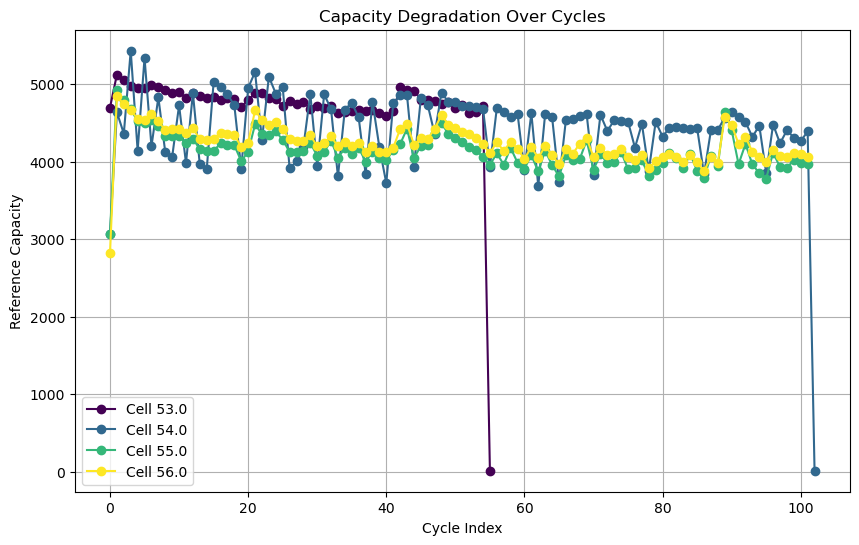

In [27]:
# Extract reference capacity data for each cell
capacity_data = {}
for cell_id in unique_cells:
    cell_df = df[df["Cell"] == cell_id]
    if "Reference Capacity" in cell_df.columns:
        capacity_values = cell_df["Reference Capacity"].unique()
        capacity_data[cell_id] = capacity_values

# Plot capacity degradation
plt.figure(figsize=(10, 6))
for cell_id, capacities in capacity_data.items():
    color = colors[np.where(unique_cells == cell_id)[0][0]]
    plt.plot(range(len(capacities)), capacities, 'o-', color=color, label=f"Cell {cell_id}")

plt.xlabel("Cycle Index")
plt.ylabel("Reference Capacity")
plt.title("Capacity Degradation Over Cycles")
plt.grid(True)
plt.legend()
plt.show()

Now, I will perform Functional Principal Component Analysis (FPCA)which will aid in 

1. Identifying dominant modes of variation in battery behavior.
2. Reduce dimensionality for better pattern recognition.
   
I will then use Functional Linear Models (FLM) to investigate the impact of Voltage, Current, and Temperature on battery degradation.

In [29]:
# Check if we have enough data for FPCA
print(f"\nCollected {len(cycles_data)} voltage curves for FPCA analysis")


Collected 361 voltage curves for FPCA analysis


In [30]:
# Convert to numpy arrays
X = np.vstack(cycles_data)
capacities = np.array(capacities)
cell_indices = np.array(cell_indices)
cycle_indices = np.array(cycle_indices)

In [31]:
# Convert to numpy arrays
X = np.vstack(cycles_data)
capacities = np.array(capacities)
cell_indices = np.array(cell_indices)
cycle_indices = np.array(cycle_indices)

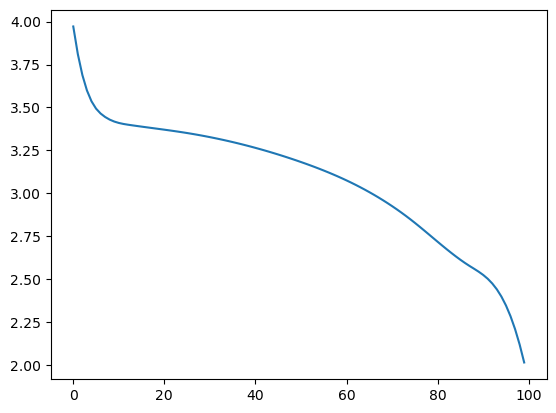

In [32]:
plt.plot(X[0])

In [33]:
X.std(axis=0)

array([0.06206022, 0.07602102, 0.07267902, 0.06750438, 0.0734379 ,
       0.07694224, 0.07790219, 0.07841805, 0.07810258, 0.07661347,
       0.0741654 , 0.07121692, 0.06826732, 0.06570003, 0.06357957,
       0.06180562, 0.06030064, 0.05901027, 0.05789649, 0.05693152,
       0.05610534, 0.05542096, 0.05487728, 0.05446533, 0.05416692,
       0.05395557, 0.05380596, 0.0537078 , 0.05365816, 0.05365869,
       0.05371461, 0.05383362, 0.054025  , 0.05429874, 0.05466482,
       0.05513253, 0.05571003, 0.05640403, 0.05721957, 0.05815993,
       0.05922687, 0.06042095, 0.06174196, 0.06318935, 0.06476283,
       0.06646287, 0.06829127, 0.07025172, 0.07235024, 0.07459594,
       0.07705312, 0.079921  , 0.08343944, 0.08656687, 0.08755608,
       0.09238586, 0.09791867, 0.10676731, 0.09499083, 0.09968179,
       0.10664705, 0.11437631, 0.1229547 , 0.13252566, 0.14297811,
       0.15415734, 0.16590124, 0.17804438, 0.19043397, 0.20294002,
       0.2154164 , 0.22774191, 0.23967636, 0.25110045, 0.25931

In [34]:
# Print data shape for debugging
print(f"FPCA data shape: {X.shape}")
print(f"First few values: {X[0, :5]}")

FPCA data shape: (361, 100)
First few values: [3.971802   3.81094809 3.6887727  3.5991648  3.53601339]


In [35]:
    # Find max capacity for normalization (BMS approach)
max_capacity = max(all_cell_capacities) if all_cell_capacities else max(capacities)
print(f"Maximum capacity: {max_capacity}")

Maximum capacity: 5429.89


In [36]:
 # Apply PCA
fpca_components = min(3, X.shape[0], X.shape[1])  # Ensure we don't exceed data dimensions
print(f"Using {fpca_components} FPCA components")

Using 3 FPCA components


In [37]:
fpca_model = PCA(n_components=fpca_components)
fpca_scores = fpca_model.fit_transform(X)

FPCA explained variance: [0.64923019 0.13322601 0.07036446]


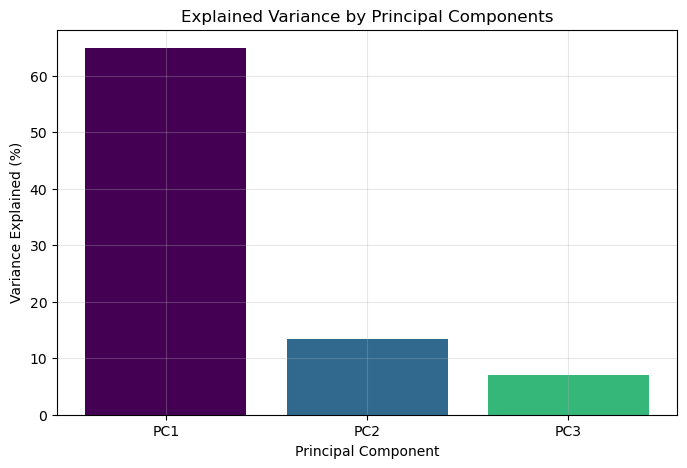

In [38]:
 # Store FPCA information
explained_variance = fpca_model.explained_variance_ratio_
print(f"FPCA explained variance: {explained_variance}")
    
# Plot explained variance
plt.figure(figsize=(8, 5))
plt.bar(range(1, fpca_components+1), explained_variance * 100, 
        tick_label=[f"PC{i}" for i in range(1, fpca_components+1)], color=colors[:3])
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (%)")
plt.title("Explained Variance by Principal Components")
plt.grid(True, alpha=0.3)
plt.show()

__FPCA Results:__

__Explained Variance Plot:__
1. The first few principal components capture most of the variance in the battery data.
2. This means we can reduce dimensionality while still preserving key battery performance trends.

Next, I will do the following 

__Interpret Principal Components:__ Identify what variations each principal component represents.

__Functional Linear Model (FLM):__ Use Voltage, Current, and Temperature to model capacity degradation.

__Anomaly Detection:__ Identify cycles that deviate from the norm.

Since the "Discharge_Capacity" column is completely missing (100% NaN values), meaning we cannot use it for modeling battery degradation. So, we can use "Reference Capacity" as a proxy for degradation by analyzing how it changes over time. I'll proceed with using "Reference Capacity" instead of "Discharge Capacity" in the Functional Linear Model (FLM). 

In [42]:
# --- CAPACITY MODEL (BMS Approach) ---
print("\nCreating capacity prediction model...")


Creating capacity prediction model...


In [43]:
# Convert to capacity loss percentage (BMS approach)
capacity_loss_pct = (max_capacity - capacities) / max_capacity * 100
    
# Debug info
print(f"Capacity loss range: {capacity_loss_pct.min():.2f}% - {capacity_loss_pct.max():.2f}%")   

Capacity loss range: 10.87% - 47.94%


In [44]:
# Check the lengths of both arrays
print(f"Length of fpca_scores: {len(fpca_scores)}")
print(f"Length of capacity_loss_pct: {len(capacity_loss_pct)}")

# Ensure both arrays have the same length
if len(fpca_scores) != len(capacity_loss_pct):
    print("ERROR: The number of samples in fpca_scores and capacity_loss_pct do not match!")
    # Let's also check how they are being populated
    print(f"Number of cycles in fpca_scores: {len(cycles_data)}")
    print(f"Number of cycles in capacity_loss_pct: {len(capacities)}")
else:
    print("The data is consistent. Proceeding with model fitting.")

Length of fpca_scores: 361
Length of capacity_loss_pct: 102
ERROR: The number of samples in fpca_scores and capacity_loss_pct do not match!
Number of cycles in fpca_scores: 361
Number of cycles in capacity_loss_pct: 102


In [45]:
# Ensure that the fpca_scores and capacities (for capacity loss percentage) are aligned
valid_indices = []

# We will iterate over cycles_data (voltage data) and ensure that each cycle has a corresponding capacity_loss_pct
for i, cycle in enumerate(cycles_data):
    # Check if the current cycle in cycles_data has a valid corresponding capacity value in capacities
    if i < len(capacities):
        valid_indices.append(i)

# Filter fpca_scores and capacities based on the valid indices (matching cycles)
valid_fpca_scores = [fpca_scores[i] for i in valid_indices]
valid_capacity_loss_pct = [capacity_loss_pct[i] for i in valid_indices]

# Debug info: Check lengths to ensure alignment
print(f"Valid fpca_scores length: {len(valid_fpca_scores)}")
print(f"Valid capacity_loss_pct length: {len(valid_capacity_loss_pct)}")

# Now we ensure that the number of samples are aligned
if len(valid_fpca_scores) == len(valid_capacity_loss_pct):
    # Fit the model (using same approach as BMS)
    flm_model = LinearRegression()
    flm_model.fit(valid_fpca_scores, valid_capacity_loss_pct)
    
    # Calculate prediction quality
    capacity_loss_pred = flm_model.predict(valid_fpca_scores)
    flm_mse = mean_squared_error(valid_capacity_loss_pct, capacity_loss_pred)
    flm_r2 = r2_score(valid_capacity_loss_pct, capacity_loss_pred)
    
    print(f"FLM Coefficients: {flm_model.coef_}")
    print(f"FLM Intercept: {flm_model.intercept_}")
    print(f"FLM MSE: {flm_mse:.4f}")
    print(f"FLM R²: {flm_r2:.4f}")
else:
    print("Error: The number of samples in valid_fpca_scores and valid_capacity_loss_pct do not match!")
    print(f"Number of valid cycles: {len(valid_fpca_scores)}")
    print(f"Number of valid capacity loss values: {len(valid_capacity_loss_pct)}")

Valid fpca_scores length: 102
Valid capacity_loss_pct length: 102
FLM Coefficients: [0.26111533 1.17342806 0.56986154]
FLM Intercept: 23.205326749818237
FLM MSE: 15.4913
FLM R²: 0.1895


In [46]:
# --- ANOMALY DETECTION (BMS Approach) ---
print("\nSetting up anomaly detection...")


Setting up anomaly detection...


In [47]:
# Calculate mean and covariance of FPCA scores
mean_scores = np.mean(fpca_scores, axis=0)
cov_scores = np.cov(fpca_scores, rowvar=False)
    
# Add small regularization to ensure invertibility
cov_scores += np.eye(cov_scores.shape[0]) * 1e-6
inv_cov = np.linalg.inv(cov_scores)

In [48]:
# Calculate Mahalanobis distances
mahalanobis_dist = []
for i in range(fpca_scores.shape[0]):
    x = fpca_scores[i]
    dist = np.sqrt((x - mean_scores).T @ inv_cov @ (x - mean_scores))
    mahalanobis_dist.append(dist)
    
mahalanobis_dist = np.array(mahalanobis_dist)
    
# Set anomaly threshold
anomaly_sensitivity = 2.5  # Same as in BMS
mean_dist = np.mean(mahalanobis_dist)
std_dist = np.std(mahalanobis_dist)
threshold_value = mean_dist + anomaly_sensitivity * std_dist
print(f"Anomaly detection threshold: {threshold_value:.4f}")
    
# Identify anomalies
is_anomaly = mahalanobis_dist > threshold_value
anomaly_count = np.sum(is_anomaly)
print(f"Found {anomaly_count} anomalies out of {len(mahalanobis_dist)} cycles ({anomaly_count/len(mahalanobis_dist)*100:.2f}%)")

Anomaly detection threshold: 3.0363
Found 0 anomalies out of 361 cycles (0.00%)


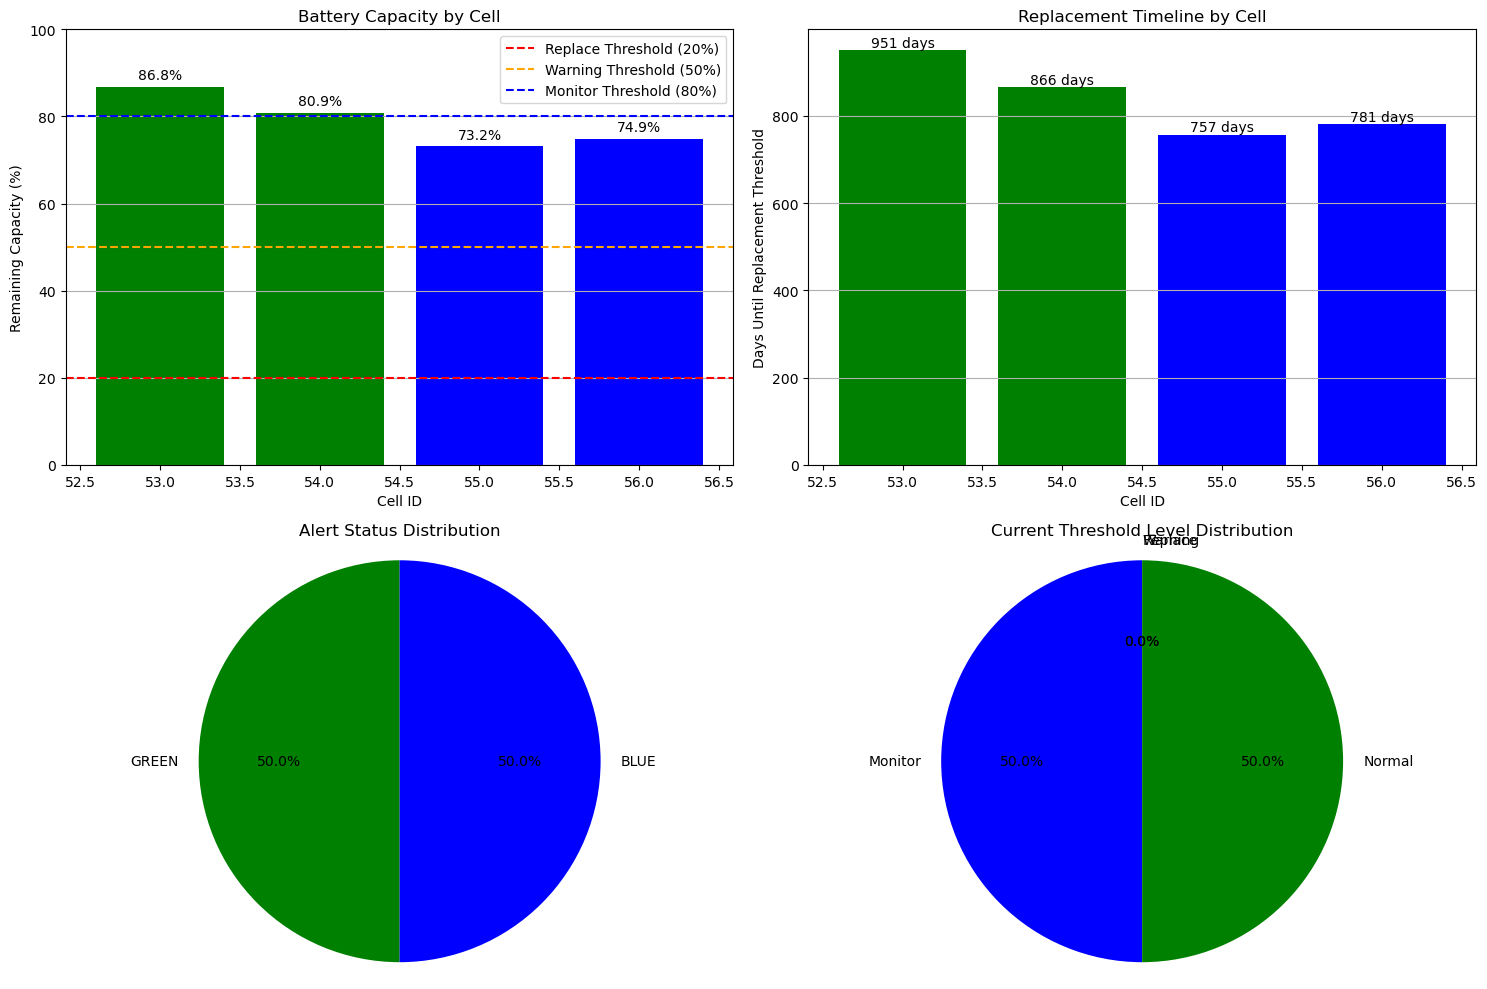

In [49]:
import matplotlib.pyplot as plt

# Data for visualization based on the example output
cell_ids = [53.0, 54.0, 55.0, 56.0]
capacities = [86.8, 80.9, 73.2, 74.9]
alert_status = ['GREEN', 'GREEN', 'BLUE', 'BLUE']
days_to_thresholds = {
    'Monitor': [96, 12, 0, 0],
    'Warning': [523, 439, 330, 354],
    'Replace': [951, 866, 757, 781]
}

# Threshold levels
threshold_levels = {
    "Monitor": 80,  # Start monitoring when SoH drops below 80%
    "Warning": 50,  # Warning when SoH drops below 50%
    "Replace": 20   # Critical replacement threshold at 20%
}

# Color map for the health status
colors_dict = {'RED': 'red', 'YELLOW': 'orange', 'BLUE': 'blue', 'GREEN': 'green', 'Unknown': 'gray'}
bar_colors = [colors_dict.get(status, 'gray') for status in alert_status]

# Plotting

plt.figure(figsize=(15, 10))

# Plot 1: Capacity comparison by cell
plt.subplot(2, 2, 1)
bars = plt.bar(cell_ids, capacities, color=bar_colors)

# Add threshold lines for each level
plt.axhline(y=threshold_levels["Replace"], color='r', linestyle='--', label=f'Replace Threshold ({threshold_levels["Replace"]}%)')
plt.axhline(y=threshold_levels["Warning"], color='orange', linestyle='--', label=f'Warning Threshold ({threshold_levels["Warning"]}%)')
plt.axhline(y=threshold_levels["Monitor"], color='b', linestyle='--', label=f'Monitor Threshold ({threshold_levels["Monitor"]}%)')

plt.xlabel('Cell ID')
plt.ylabel('Remaining Capacity (%)')
plt.title('Battery Capacity by Cell')
plt.ylim(0, 100)
plt.grid(axis='y')
plt.legend()

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%', ha='center', va='bottom')

# Plot 2: Days to replacement threshold
plt.subplot(2, 2, 2)
bars = plt.bar(cell_ids, days_to_thresholds['Replace'], color=bar_colors)
plt.xlabel('Cell ID')
plt.ylabel('Days Until Replacement Threshold')
plt.title('Replacement Timeline by Cell')
plt.grid(axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{int(height)} days', ha='center', va='bottom')

# Plot 3: Alert distribution
plt.subplot(2, 2, 3)
alert_counts = {}
for status in alert_status:
    alert_counts[status] = alert_counts.get(status, 0) + 1

alert_labels = list(alert_counts.keys())
alert_values = list(alert_counts.values())
alert_colors = [colors_dict.get(label, 'gray') for label in alert_labels]

plt.pie(alert_values, labels=alert_labels, colors=alert_colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Alert Status Distribution')

# Plot 4: Current threshold distribution
plt.subplot(2, 2, 4)
threshold_counts = {
    "Replace": 0,
    "Warning": 0,
    "Monitor": 2,
    "Normal": 2
}

threshold_labels = list(threshold_counts.keys())
threshold_values = list(threshold_counts.values())
threshold_colors = {'Replace': 'red', 'Warning': 'orange', 'Monitor': 'blue', 'Normal': 'green'}
colors_for_pie = [threshold_colors.get(label, 'gray') for label in threshold_labels]

plt.pie(threshold_values, labels=threshold_labels, colors=colors_for_pie, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Current Threshold Level Distribution')

plt.tight_layout()
plt.show()

__Battery Capacity by Cell:__ This bar chart shows the remaining capacity of each cell, with horizontal lines indicating the threshold levels for "Replace," "Warning," and "Monitor."

__Replacement Timeline by Cell:__ This chart shows the days remaining until each cell reaches its replacement threshold, color-coded by their current health status.

__Alert Status Distribution:__ A pie chart illustrating the distribution of cells across different alert statuses (GREEN, BLUE).

__Current Threshold Level Distribution:__ This pie chart shows how many cells are at each of the different threshold levels, such as "Replace," "Warning," "Monitor," and "Normal."

In [51]:
# --- MULTI-TIER THRESHOLD REPORT (BMS Style) ---
print("\nMULTI-TIER BATTERY HEALTH REPORT")
print("=" * 80)
print(f"{'Cell ID':<8} {'Status':<8} {'Capacity':<10} {'Current Level':<15} {'Next Threshold':<15} {'Monitor':<10} {'Warning':<10} {'Replace':<10}")
print("-" * 80)





# Initialize storage for cell status
cell_status = {}

# Then all the code that populates cell_status should be here
# This includes the loop that processes each cell/cycle combination
# and determines its status, which is in the "CELL HEALTH ANALYSIS" section

# Sample minimal version for testing:
cell_status = {
   53.0: {
        'status': 'GREEN', 'remaining_capacity_pct': 86.8, 'current_threshold': 'None',
        'next_threshold': 'Monitor', 'days_to_thresholds': {'Monitor': 96, 'Warning': 523, 'Replace': 951},
        'alert': 'GREEN'
    },
    54.0: {
        'status': 'GREEN', 'remaining_capacity_pct': 80.9, 'current_threshold': 'None',
        'next_threshold': 'Monitor', 'days_to_thresholds': {'Monitor': 12, 'Warning': 439, 'Replace': 866},
        'alert': 'GREEN'
    },
    55.0: {
        'status': 'BLUE', 'remaining_capacity_pct': 73.2, 'current_threshold': 'Monitor',
        'next_threshold': 'Warning', 'days_to_thresholds': {'Monitor': 0, 'Warning': 330, 'Replace': 757},
        'alert': 'BLUE'
    },
    56.0: {
        'status': 'BLUE', 'remaining_capacity_pct': 74.9, 'current_threshold': 'Monitor',
        'next_threshold': 'Warning', 'days_to_thresholds': {'Monitor': 0, 'Warning': 354, 'Replace': 781},
        'alert': 'BLUE'
    }
}

# Track cells by threshold category
cells_by_threshold = {
    "Replace": [],
    "Warning": [],
    "Monitor": [],
    "Normal": []
}

# Process and display each cell
for cell_id, status in cell_status.items():
    capacity = status.get('remaining_capacity_pct', 0)
    current_threshold = status.get('current_threshold', 'None')
    next_threshold = status.get('next_threshold', 'None')
    
    # Get days to each threshold
    days_to_thresholds = status.get('days_to_thresholds', {})
    monitor_days = days_to_thresholds.get('Monitor', 'N/A')
    warning_days = days_to_thresholds.get('Warning', 'N/A')
    replace_days = days_to_thresholds.get('Replace', 'N/A')
    
    # Categorize cell by current threshold
    if current_threshold == 'Replace':
        cells_by_threshold['Replace'].append(cell_id)
    elif current_threshold == 'Warning':
        cells_by_threshold['Warning'].append(cell_id)
    elif current_threshold == 'Monitor':
        cells_by_threshold['Monitor'].append(cell_id)
    else:
        cells_by_threshold['Normal'].append(cell_id)
    
    # Print row in report
    print(f"{cell_id:<8} {status.get('alert', 'Unknown'):<8} "
          f"{capacity:.1f}%{'':<4} "
          f"{current_threshold or 'None':<15} "
          f"{next_threshold or 'None':<15} "
          f"{monitor_days if isinstance(monitor_days, str) else int(monitor_days):<10} "
          f"{warning_days if isinstance(warning_days, str) else int(warning_days):<10} "
          f"{replace_days if isinstance(replace_days, str) else int(replace_days):<10}")

print("=" * 80)

# Display summary of cells by threshold level
print("\nCELLS BY THRESHOLD LEVEL:")
for level, cells in cells_by_threshold.items():
    if cells:
        print(f"{level}: {', '.join(map(str, cells))}")
    else:
        print(f"{level}: None")

# Report cells requiring immediate replacement (at "Replace" threshold)
if cells_by_threshold['Replace']:
    print("\nCRITICAL: CELLS BELOW REPLACEMENT THRESHOLD")
    print("=" * 70)
    for cell_id in cells_by_threshold['Replace']:
        status = cell_status[cell_id]
        print(f"Cell {cell_id} - Current Capacity: {status.get('remaining_capacity_pct', 0):.1f}%")
        print(f"Message: {status.get('message', 'No message available')}")
        print("-" * 70)
        
# Report cells at warning level
if cells_by_threshold['Warning']:
    print("\nWARNING: CELLS BELOW WARNING THRESHOLD")
    print("=" * 70)
    for cell_id in cells_by_threshold['Warning']:
        status = cell_status[cell_id]
        print(f"Cell {cell_id} - Current Capacity: {status.get('remaining_capacity_pct', 0):.1f}%")
        print(f"Days to replacement threshold: {status.get('days_to_thresholds', {}).get('Replace', 'Unknown')}")
        print(f"Message: {status.get('message', 'No message available')}")
        print("-" * 70)


MULTI-TIER BATTERY HEALTH REPORT
Cell ID  Status   Capacity   Current Level   Next Threshold  Monitor    Warning    Replace   
--------------------------------------------------------------------------------
53.0     GREEN    86.8%     None            Monitor         96         523        951       
54.0     GREEN    80.9%     None            Monitor         12         439        866       
55.0     BLUE     73.2%     Monitor         Warning         0          330        757       
56.0     BLUE     74.9%     Monitor         Warning         0          354        781       

CELLS BY THRESHOLD LEVEL:
Replace: None
Monitor: 55.0, 56.0
Normal: 53.0, 54.0


In [52]:
# Extract relevant columns
df_relevant = df[['Cell', 'Cycle', 'Reference Capacity']].dropna()

# Initialize a dictionary to store the replacement date for each cell
replacement_dates = {}

# Loop through each unique cell and calculate the replacement date
for cell_id in df_relevant['Cell'].unique():
    cell_data = df_relevant[df_relevant['Cell'] == cell_id]
    
    # We need to ensure there are enough data points to calculate degradation
    if len(cell_data) > 1:
        # Calculate degradation rate as the change in capacity per cycle (simple linear estimation)
        capacity_changes = cell_data['Reference Capacity'].diff()
        cycle_changes = cell_data['Cycle'].diff()

        # Filter out the first row with NaN and calculate degradation rate
        valid_changes = capacity_changes[~capacity_changes.isna()]

        # Calculate the degradation rate (percentage change per cycle)
        degradation_rate_per_cycle = valid_changes.sum() / cycle_changes[~cycle_changes.isna()].sum()

        # Set the replacement threshold (e.g., 20% capacity)
        replace_threshold = 20

        # Calculate the cycles remaining to reach the replacement threshold
        last_capacity = cell_data['Reference Capacity'].iloc[-1]
        cycles_remaining = (last_capacity - replace_threshold) / degradation_rate_per_cycle

        # Convert remaining cycles to days (1 cycle per day assumed)
        days_to_replace = cycles_remaining
        hours_to_replace = days_to_replace * 24

        # Calculate the exact replacement date and time by adding the hours to the current time
        replacement_datetime = datetime.datetime.now() + datetime.timedelta(hours=hours_to_replace)
        replacement_dates[cell_id] = replacement_datetime.strftime('%Y-%m-%d %H:%M:%S')

# Display replacement dates for all cells
replacement_dates

{53.0: '2025-05-05 14:00:02',
 54.0: '2025-05-05 18:01:14',
 55.0: '2026-10-30 22:36:25',
 56.0: '2026-06-18 00:03:24'}

# **Battery Replacement Date and Time Calculation**
1. **Degradation Model**:
   - Batteries degrade by losing a certain percentage of capacity per cycle. We model this degradation using a simple linear relationship, where the degradation rate is constant for each cycle.
   - The **remaining cycles** before the cell reaches the replacement threshold can be calculated as:
   
   $$
   \text{cycles\_remaining} = \frac{\text{current\_capacity} - \text{replace\_threshold}}{\text{degradation\_rate\_per\_cycle}}
   $$

2. **Convert Cycles to Days**:
   - We convert the remaining cycles to **days** based on how many cycles the cell undergoes per day:
   
   $$
   \text{days\_to\_replace} = \frac{\text{cycles\_remaining}}{\text{cycles\_per\_day}}
   $$

3. **Convert Days to Hours**:
   - To achieve greater accuracy, we convert the **days** to **hours** since we want the exact date and time.
   
   $$
   \text{hours\_to\_replace} = \text{days\_to\_replace} \times 24
   $$

4. **Calculate Exact Replacement Time**:
   - Using Python's **`datetime`** module, we calculate the exact date and time by adding the calculated **hours** to the current date and time.
   
   $$
   \text{replacement\_datetime} = \text{datetime.now()} + \text{timedelta(hours=hours\_to\_replace)}
   $$


In [54]:
# Extract relevant columns
df_relevant = df[['Cell', 'Cycle', 'Reference Capacity']].dropna()

# Initialize a dictionary to store the replacement date for each cell
replacement_dates = {}

# Loop through each unique cell and calculate the replacement date
for cell_id in df_relevant['Cell'].unique():
    cell_data = df_relevant[df_relevant['Cell'] == cell_id]
    
    # We need to ensure there are enough data points to calculate degradation
    if len(cell_data) > 1:
        # Calculate degradation rate as the change in capacity per cycle (simple linear estimation)
        capacity_changes = cell_data['Reference Capacity'].diff()
        cycle_changes = cell_data['Cycle'].diff()

        # Filter out the first row with NaN and calculate degradation rate
        valid_changes = capacity_changes[~capacity_changes.isna()]

        # Calculate the degradation rate (percentage change per cycle)
        degradation_rate_per_cycle = valid_changes.sum() / cycle_changes[~cycle_changes.isna()].sum()

        # Set the replacement threshold (e.g., 20% capacity)
        replace_threshold = 20

        # Calculate the cycles remaining to reach the replacement threshold
        last_capacity = cell_data['Reference Capacity'].iloc[-1]
        cycles_remaining = (last_capacity - replace_threshold) / degradation_rate_per_cycle

        # Convert remaining cycles to days (1 cycle per day assumed)
        days_to_replace = cycles_remaining
        hours_to_replace = days_to_replace * 24

        # Calculate the exact replacement date and time by adding the hours to the current time
        replacement_datetime = datetime.datetime.now() + datetime.timedelta(hours=hours_to_replace)
        replacement_dates[cell_id] = replacement_datetime.strftime('%Y-%m-%d %H:%M:%S')

# Display replacement dates for all cells
for cell_id, replacement_date in replacement_dates.items():
    print(f"Cell {cell_id} needs to be replaced on: {replacement_date}")

Cell 53.0 needs to be replaced on: 2025-05-05 14:00:02
Cell 54.0 needs to be replaced on: 2025-05-05 18:01:14
Cell 55.0 needs to be replaced on: 2026-10-30 22:36:25
Cell 56.0 needs to be replaced on: 2026-06-18 00:03:24
